# Profiling the unoptimized model
In order to understand what the total computation time is composed of, we profile an execution of the unoptimized simulation. A parallelization attempt might be sensible if the function calls that take most time can be refactored to run across multiple workers in parallel.

Here we use cProfile to perform the profiling. (For the data used in the report this was done on a consumer-grade laptop.)

In [1]:
import cProfile
from unoptimized.nmwc_model.solver import run_unoptimized

In [9]:
cProfile.run("run_unoptimized()", "unoptimized_cProfile")

Writing output...

Writing output...

Writing output...

Writing output...

Writing output...

Writing output...

Writing output...

Writing output...

Writing output...

Writing output...

Writing output...

Elapsed computation time without writing: 489.578 s

Start wrtiting output.

Writing to file output_unoptimized.npz 

Output contains 11 output steps



Let's now analyze the saved profile using pstats. What we're interested in is the function calls from inside the `solver.py` entrypoint and how they constitute the total execution time.

In [2]:
import pstats
import matplotlib.pyplot as plt
import numpy as np
import io

In [3]:
s = io.StringIO()
ps = pstats.Stats('unoptimized_cProfile', stream=s)
ps.sort_stats('cumulative')
profile_data = ps.stats

cumulative_times = {}

for func_name, func_stats in profile_data.items():
    callers = func_stats[4]
    filename = func_name[0] 
    
    for caller, caller_stats in callers.items():
        caller_filename = caller[0]
        # We're interested in the calls originating from `solver.py`
        # and the function called should be part of the `nmwc_model` package
        if "solver.py" in filename or "solver.py" in caller_filename and "nmwc_model" in filename:
            cumulative_time = func_stats[3]
            cumulative_times[func_name[2]] = cumulative_time

cumulative_times = {k: v for k, v in sorted(cumulative_times.items(), key=lambda item: -item[1]) if v > 1}
cumulative_times

{'run_unoptimized': 490.046745482,
 'kessler': 239.029688235,
 'horizontal_diffusion': 96.233944483,
 'prog_moisture': 44.636543186000004,
 'diag_montgomery': 29.061834211,
 'diag_height': 27.534018785,
 'prog_isendens': 21.429133926000002,
 'prog_velocity': 16.69173753,
 'diag_pressure': 8.824968238}

Finally, we visualize the breakdown of the total computation time inside the `solver.py` file, as distrubuted among the calls of functions that are part of the simulation. Please note that the profiling was performed on a different machine than the one used as a reference "consumer-grade" laptop in the single-node benchmarking.

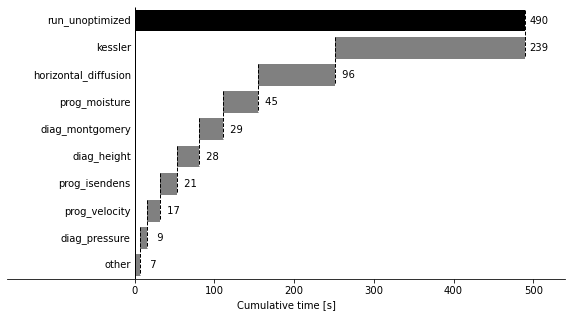

In [4]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), sharex=True)

total_offset = cumulative_times["run_unoptimized"]

for i, (name, time) in enumerate(cumulative_times.items()):
    left_offset = (total_offset := total_offset - time) if name != "run_unoptimized" else 0
    ax1.barh(-i, time, left=left_offset, color="k" if name == "run_unoptimized" else "gray")
    ax1.text(-5, -i, name, horizontalalignment="right", verticalalignment="center")
    ax1.text(left_offset + time + 5, -i, f"{time:3.0f}", horizontalalignment="left", verticalalignment="center")
    if name != "run_unoptimized":
        ax1.vlines(left_offset + time, -i + 1.4, -i - 0.35, color="k", linewidth=1, linestyles="dashed")

last_y = len(cumulative_times)
ax1.barh(-last_y, left_offset, color="gray")
ax1.text(-5, -last_y, "other", horizontalalignment="right", verticalalignment="center")
ax1.text(left_offset + 5, -last_y, f"{left_offset:3.0f}", horizontalalignment="left", verticalalignment="center")
ax1.vlines(left_offset, -last_y + 1.4, -last_y - 0.35, color="k", linewidth=1, linestyles="dashed")

ax1.axes.get_yaxis().set_visible(False)
ax1.set_xlabel("Cumulative time [s]")
ax1.set_xticks(np.arange(0, 530, 100))
ax1.set_xlim((-160, 540))
ax1.set_ylim(-last_y - 0.5, 0.5)
ax1.vlines(0, -last_y - 0.5, 0.5, color="k", linewidth=1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)

fig.savefig("profile-unoptimized.pdf", bbox_inches="tight")